#### Step 0 - Import Spark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
!tar -xvf spark-3.3.3-bin-hadoop3.tgz
!pip install findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import requests
import json
import numpy as np

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.memory', '8g')\
        .config('spark.driver.memory', '4g')\
        .getOrCreate()

sc = spark.sparkContext

--2023-12-14 19:18:37--  https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299426263 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.3-bin-hadoop3.tgz.2’

spark-3.3.3-bin-had 100%[===================>] 285.55M   131MB/s    in 2.2s    

2023-12-14 19:18:40 (131 MB/s) - ‘spark-3.3.3-bin-hadoop3.tgz.2’ saved [299426263/299426263]

spark-3.3.3-bin-hadoop3/
spark-3.3.3-bin-hadoop3/LICENSE
spark-3.3.3-bin-hadoop3/NOTICE
spark-3.3.3-bin-hadoop3/R/
spark-3.3.3-bin-hadoop3/R/lib/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.3-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

# Data Pre-Processing

## Macro-Scale Data Pre-Processing


This section contains data pre-processing for our larger-scale macro economics. We will be joining these rows horizontally on their "YEAR" column, and concatenating the data into one long tuple.

It includes the following datasets
* Prosperity Indicator
* Census Data
* Interprovincial Migration Data
* Historical CPI

Our Intermediate Dataset will have the following attributes:
* Assessed Year
* Average Home Price
* Unemployment Rate
* Housing Starts
* City Population
* Interpovincial Immigration
* Inflation Rate

### Prosperity Indicator - Pre-Processing

#### Step 1 - Import Data

In [ ]:
filename = "Calgary_prosperous_average.csv"

rdd_import = (sc.textFile(filename, 6))

print(rdd_import.take(1))

['2017,463.3666666666666,961.1666666666666,2.6624062087645566,8.558333333333334']


#### Step 2 - Filter Rows

In our dataset, we have the following columns:

0 : year
1 : average_home_price_thousands
2 : housing_starts
3 : retail_sales_in_billion
4 : unemployment_rate


We are interested in all columns

In [ ]:
def extractFields(record):
    """Creates a record consisting of month, year,
    average_home_price_thousands,housing_starts,retail_sales_in_billion,unemployment_rate

    Args:
        record : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: a comma separated record
        (year,average_home_price_thousands,housing_starts,retail_sales_in_billion,unemployment_rate)
    """

    fieldsList = record.split(',')
    return (fieldsList[0],fieldsList[1],fieldsList[2],fieldsList[3],fieldsList[4])

print(extractFields(rdd_import.take(1)[0]))

('2017', '463.3666666666666', '961.1666666666666', '2.6624062087645566', '8.558333333333334')


In [ ]:
extracted_rdd = rdd_import.map(extractFields)
print(extracted_rdd.take(5))

[('2017', '463.3666666666666', '961.1666666666666', '2.6624062087645566', '8.558333333333334'), ('2018', '458.09999999999997', '914.25', '2.65', '7.633333333333333'), ('2019', '441.825', '992.4166666666666', '2.716666666666667', '7.091666666666666')]


In [ ]:
# YEAR (0)
# Convert census_year from string to int
def string_to_int(record):
    """
    Converts a string datatype into an integer datatype

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with year as integer year.

    """
    if record[0] is not None:
        try:
            year_int = int(record[0])  # Convert to integer
        except ValueError:
            pass
    return (year_int,record[1],record[2], record[3], record[4])
extracted_rdd = extracted_rdd.map(string_to_int)

In [ ]:
def filterYear(record):
  """Ignores records outside years 2017-2019

  Args:
    record: a comma separated string consisting of all fields in the rdd.

  Returns:
    True if the date is 2017 to 2019, false otherwise.
  """

  if record[0] >= 2017:
    if record[0] <= 2019:
      return True
  else:
    return False

filtered_rdd = extracted_rdd.filter(filterYear)
print(filtered_rdd.take(20))

[(2017, '463.3666666666666', '961.1666666666666', '2.6624062087645566', '8.558333333333334'), (2018, '458.09999999999997', '914.25', '2.65', '7.633333333333333'), (2019, '441.825', '992.4166666666666', '2.716666666666667', '7.091666666666666')]


#### Step 3 - Inspect Data Quality

Check for missing, incorrect, or duplicate data.

In [ ]:
#Check RDD for missing values
null_values_rdd = filtered_rdd.filter(lambda x: any(value is None for value in x))

# Print the first 20 elements with null values
print(null_values_rdd.take(10))

[]


In [ ]:
# Filter out rows with missing values
prosperous_rdd0 = filtered_rdd.filter(lambda record: all(value != "" for value in record))

In [ ]:
# Convert the values to floats and group by the year
def convert(record):
    return (record[0], float(record[1]), float(record[2]), float(record[3]), float(record[4]))
prosperous_rdd = prosperous_rdd0.map(convert)

print(prosperous_rdd.take(5))

[(2017, 463.3666666666666, 961.1666666666666, 2.6624062087645566, 8.558333333333334), (2018, 458.09999999999997, 914.25, 2.65, 7.633333333333333), (2019, 441.825, 992.4166666666666, 2.716666666666667, 7.091666666666666)]


In [ ]:
# Scaling data to actual values
prosperous_rdd = prosperous_rdd.map(lambda row: (row[0],
                                  row[1] * 1000, # converting average home price in thousands
                                  row[2] * 12, # converting avg monthly housing starts to yearly
                                  row[3] * 10**9, # converting retail sales in billions
                                  row[4]))

In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
prosperous_df = prosperous_rdd.toDF(["Year", "average_home_price", "housing_starts", "retail_sales", "unemployment_rate"])
prosperous_df.show()
prosperous_df.cache()

+----+------------------+--------------+--------------------+-----------------+
|Year|average_home_price|housing_starts|        retail_sales|unemployment_rate|
+----+------------------+--------------+--------------------+-----------------+
|2017| 463366.6666666666|       11534.0|2.6624062087645564E9|8.558333333333334|
|2018|458099.99999999994|       10971.0|              2.65E9|7.633333333333333|
|2019|          441825.0|       11909.0| 2.716666666666667E9|7.091666666666666|
+----+------------------+--------------+--------------------+-----------------+



DataFrame[Year: bigint, average_home_price: double, housing_starts: double, retail_sales: double, unemployment_rate: double]

In [ ]:
prosperous_df.describe

<bound method DataFrame.describe of DataFrame[Year: bigint, average_home_price: double, housing_starts: double, retail_sales: double, unemployment_rate: double]>

### Census Data - Pre-Processing

#### Step 1 - Import Data

In [ ]:
# Define the API URL
census_api_url = "https://data.calgary.ca/resource/set9-futw.json?$limit=500000&$offset=0"

# Make the API request and get the JSON response
response = requests.get(census_api_url)

# Check that API connection succeeded
if response.status_code == 200:
    data = response.json()
    print("API connection successful")
else:
    print("Failed to retrieve data. Status code: ", response.status_code)

API connection successful


In [ ]:
# Create an RDD from the JSON data
census_rdd = sc.parallelize(data, 8)

#### Step 2 - Extract Columns

In [ ]:
# Extract the desired columns using map
selected_columns = ['census_year', 'code', 'community', 'dwelling_type', 'dwelling_type_code', 'dwelling_cnt', 'resident_cnt']

def extract_columns(record):
    """
    Extracts selected columns by column name from the rdd.

    Args:
        record: a comma separated line representing all columns from the API json.

    Returns:
        key-value pairs containing keys that match the selected columns.
    """
    return {key: record.get(key) for key in selected_columns}

census_rdd = census_rdd.map(extract_columns)

In [ ]:
# Extract the fields relevant to the analysis and remove JSON format
def extractFields(record):
    mylist = [i for i in record.values()]
    return(mylist[0],mylist[1],mylist[2],mylist[3],mylist[4],mylist[5],mylist[6])

extracted_rdd = census_rdd.map(extractFields)
print("Total number of records: ", extracted_rdd.count())

print(extracted_rdd.take(5))

Total number of records:  26890
[('2019', 'ABB', 'ABBEYDALE', 'SINGLE FAMILY HOME', '1', '1418', '4211'), ('2019', 'ABB', 'ABBEYDALE', 'HOTELS, MOTELS  RESIDENCE', '13', '1', '17'), ('2019', 'ABB', 'ABBEYDALE', 'DUPLEX', '2', '290', '848'), ('2019', 'ABB', 'ABBEYDALE', 'TOWN HOUSE', '5', '230', '732'), ('2019', 'ABB', 'ABBEYDALE', 'CONVERTED STRUCTURE', '7', '130', '149')]


In [ ]:
def extractResidential(record):
  if (record[3] == 'SINGLE FAMILY HOME'):
    return True
  else:
    return False

extracted_rdd = extracted_rdd.filter(extractResidential)
print("Total number of records: ", extracted_rdd.count())
for record in extracted_rdd.take(10):
    print(record)

Total number of records:  4832
('2019', 'ABB', 'ABBEYDALE', 'SINGLE FAMILY HOME', '1', '1418', '4211')
('2019', 'ABP', 'AURORA BUSINESS PARK', 'SINGLE FAMILY HOME', '1', '0', '0')
('2019', 'ACA', 'ACADIA', 'SINGLE FAMILY HOME', '1', '2282', '5360')
('2019', 'ALB', 'ALBERT PARK/RADISSON HEIGHTS', 'SINGLE FAMILY HOME', '1', '909', '2305')
('2019', 'ALT', 'ALTADORE', 'SINGLE FAMILY HOME', '1', '1367', '3559')
('2019', 'APP', 'APPLEWOOD PARK', 'SINGLE FAMILY HOME', '1', '1371', '5036')
('2019', 'ARB', 'ARBOUR LAKE', 'SINGLE FAMILY HOME', '1', '2682', '8373')
('2019', 'ASP', 'ASPEN WOODS', 'SINGLE FAMILY HOME', '1', '2202', '7745')
('2019', 'AUB', 'AUBURN BAY', 'SINGLE FAMILY HOME', '1', '3790', '12959')
('2019', 'AYB', 'ALYTH/BONNYBROOK', 'SINGLE FAMILY HOME', '1', '9', '0')


#### Step 3 - Data Filtering & Pre-Processing

In [ ]:
# Convert census_year from string to int
def string_to_int(record):
    """
    Converts a string datatype into an integer datatype

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with year as integer year.

    """
    if record[0] is not None:
        try:
            year_int = int(record[0])  # Convert to integer
        except ValueError:
            pass
    return (year_int,record[1],record[2], record[3], record[4],record[5],record[6])
extracted_rdd = extracted_rdd.map(string_to_int)
print(extracted_rdd.take(5))

[(2019, 'ABB', 'ABBEYDALE', 'SINGLE FAMILY HOME', '1', '1418', '4211'), (2019, 'ABP', 'AURORA BUSINESS PARK', 'SINGLE FAMILY HOME', '1', '0', '0'), (2019, 'ACA', 'ACADIA', 'SINGLE FAMILY HOME', '1', '2282', '5360'), (2019, 'ALB', 'ALBERT PARK/RADISSON HEIGHTS', 'SINGLE FAMILY HOME', '1', '909', '2305'), (2019, 'ALT', 'ALTADORE', 'SINGLE FAMILY HOME', '1', '1367', '3559')]


In [ ]:
def filterYear(record):
    """
    Filters the data to extract only the years relevant to the analysis.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        True if the date is 2017 to 2019, false otherwise.

    """
    if record[0] >= 2017:
        if record[0] <= 2019:
            return True
    else:
        return False

In [ ]:
# Apply the functions to modify and filter the year values
rdd = extracted_rdd.filter(filterYear)
print(rdd.take(5))
print('Total of records in 2017 to 2019: ', rdd.count())

[(2019, 'ABB', 'ABBEYDALE', 'SINGLE FAMILY HOME', '1', '1418', '4211'), (2019, 'ABP', 'AURORA BUSINESS PARK', 'SINGLE FAMILY HOME', '1', '0', '0'), (2019, 'ACA', 'ACADIA', 'SINGLE FAMILY HOME', '1', '2282', '5360'), (2019, 'ALB', 'ALBERT PARK/RADISSON HEIGHTS', 'SINGLE FAMILY HOME', '1', '909', '2305'), (2019, 'ALT', 'ALTADORE', 'SINGLE FAMILY HOME', '1', '1367', '3559')]
Total of records in 2017 to 2019:  718


#### Step 4 - Cleaning Data

In [ ]:
# Since these community is very new with very few resident, and they do
# not have a resident name, they can be dropped from the data

census_rdd = rdd.filter(lambda row: all(value is not None for value in row))
print(census_rdd.count())

704


In [ ]:
def reorder(row):
  return (row[0], row[1], int(row[5]), int(row[6]))

# Reorder Columns
census_rdd = census_rdd.map(reorder)

In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
census_df = census_rdd.toDF(["Year", "Community_Code", 'dwelling_cnt', 'resident_cnt'])
census_df.show()
census_df.cache()

+----+--------------+------------+------------+
|Year|Community_Code|dwelling_cnt|resident_cnt|
+----+--------------+------------+------------+
|2019|           ABB|        1418|        4211|
|2019|           ABP|           0|           0|
|2019|           ACA|        2282|        5360|
|2019|           ALB|         909|        2305|
|2019|           ALT|        1367|        3559|
|2019|           APP|        1371|        5036|
|2019|           ARB|        2682|        8373|
|2019|           ASP|        2202|        7745|
|2019|           AUB|        3790|       12959|
|2019|           AYB|           9|           0|
|2019|           BDO|         368|         912|
|2019|           BED|        2599|        7152|
|2019|           BEL|         159|         390|
|2019|           BLM|         114|          84|
|2019|           BLN|          50|          63|
|2019|           BLN|          21|          15|
|2019|           BNF|         997|        2445|
|2019|           BNK|         483|      

DataFrame[Year: bigint, Community_Code: string, dwelling_cnt: bigint, resident_cnt: bigint]

### Interprovincial Migration Data - Pre-Processing

#### Step 1 - Import Data

In [ ]:
#import csv Interprovincial Migration Data file and create rdd
interprovincial_file = "17100022.csv"
rdd_interprovincial = sc.textFile(interprovincial_file,minPartitions=8)

#get the header and filter out the header in the rdd, and then turn the rdd to [index,tuple] format
header = rdd_interprovincial.first()
rdd_interprovincial = rdd_interprovincial.filter(lambda row : row != header)

# Remove double quotes from each row
rdd_interprovincial = rdd_interprovincial.map(lambda row: row.replace('"', ''))

#### Step 2 - Extract Columns

In [ ]:
# Extract the fields relevant to the analysis
def interp_extractFields(record):
    fieldsList=record.split(',')
    return(fieldsList[0],fieldsList[4],fieldsList[12])

print(interp_extractFields(rdd_interprovincial.take(1)[0]))

('1971/1972', 'Prince Edward Island', '141')


In [ ]:
rdd_interprovincial=rdd_interprovincial.map(interp_extractFields)
print(rdd_interprovincial.take(2))

[('1971/1972', 'Prince Edward Island', '141'), ('1971/1972', 'Nova Scotia', '1451')]


#### Step 3 - Filter Columns

In [ ]:
#functions to filter the province of destination values and year values
def interp_filterYear(record):
    """
    Filters the data to extract only the years relevant to the analysis.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        True if the date is 2017 to 2019, false otherwise.

    """
    if (record[0] =='2016/2017' or record[0] =='2017/2018' or record[0] =='2018/2019') and (record[1]=='Alberta'):
        return True
    else:
        return False

In [ ]:
# Apply the functions to filter the year values
rdd_interprovincial = (rdd_interprovincial.filter(interp_filterYear))
print(rdd_interprovincial.take(2))

[('2016/2017', 'Alberta', '1828'), ('2016/2017', 'Alberta', '401')]


In [ ]:
#drop the province column
def dropAlbertaColumn(record):
  return (record[0],record[2])
rdd_interprovincial=rdd_interprovincial.map(dropAlbertaColumn)
print(rdd_interprovincial.take(5))

[('2016/2017', '1828'), ('2016/2017', '401'), ('2016/2017', '2466'), ('2016/2017', '1586'), ('2016/2017', '2758')]


In [ ]:
#get count for each year
interprovincial_rdd=rdd_interprovincial.reduceByKey(lambda x,y:int(x)+int(y))
print(interprovincial_rdd.collect())

[('2016/2017', 50396), ('2018/2019', 52796), ('2017/2018', 55147)]


In [ ]:
#change the format of year i.e. from 2016/2017 to 2017
def interp_changeYearFormat(record):
    # Convert the tuple to a list
    record_list = list(record)

    # Modify the first element of the list based on conditions and turn that into an int
    if record_list[0] == '2016/2017':
        record_list[0] = 2017
    elif record_list[0] == '2017/2018':
        record_list[0] = 2018
    elif record_list[0] == '2018/2019':
        record_list[0] = 2019

    # Convert the list back to a tuple
    return tuple(record_list)
interprovincial_rdd=interprovincial_rdd.map(interp_changeYearFormat)
print(interprovincial_rdd.take(3))


[(2017, 50396), (2019, 52796), (2018, 55147)]


In [ ]:
print("Interprovincial Migration Data by year: (year,count)")

for record in interprovincial_rdd.take(5):
    print(record)

Interprovincial Migration Data by year: (year,count)
(2017, 50396)
(2019, 52796)
(2018, 55147)


In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
interprovincial_df = interprovincial_rdd.toDF(["Year", "Migration Count"])
interprovincial_df.show()
interprovincial_df.cache()

+----+---------------+
|Year|Migration Count|
+----+---------------+
|2017|          50396|
|2019|          52796|
|2018|          55147|
+----+---------------+



DataFrame[Year: bigint, Migration Count: bigint]

### Historical CPI - Pre-Processing

#### Step 1 - Import Data

In [ ]:
rdd = sc.textFile("1810025901_databaseLoadingData.csv", 8)
rdd.take(3)

['"REF_DATE","GEO","DGUID","Alternative measures","Release","UOM","UOM_ID","SCALAR_FACTOR","SCALAR_ID","VECTOR","COORDINATE","VALUE","STATUS","SYMBOL","TERMINATED","DECIMALS"',
 '"2017-01","Canada","","Measure of core inflation based on a factor model, CPI-common (year-over-year percent change)","November 21, 2023","Percent","239","units","0","v1577650064","1.1.84","1.2","","","","1"',
 '"2017-02","Canada","","Measure of core inflation based on a factor model, CPI-common (year-over-year percent change)","November 21, 2023","Percent","239","units","0","v1577650064","1.1.84","1.2","","","","1"']

#### Step 2 - Extract Fields

In [ ]:
def extractFields(record):
    """Creates a record consisting of date, alternative measures, and value.

    Args:
        record : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: a comma separated record (date, alternative measures, value)
    """
    line = record.replace('"', '').split(',')
    if len(line) >= 12:
        return (line[0], line[4], line[13])
    else:
        return None

# RDD columns
# 0: date
# 1: alternative measures
# 2: value

rdd_extracted = rdd.map(extractFields)

print("Number of records: ", rdd_extracted.count())
# print the first few records
for record in rdd_extracted.take(5):
    print(record)

Number of records:  903
('REF_DATE', 'Release', 'SYMBOL')
('2017-01', ' CPI-common (year-over-year percent change)', '1.2')
('2017-02', ' CPI-common (year-over-year percent change)', '1.2')
('2017-03', ' CPI-common (year-over-year percent change)', '1.1')
('2017-04', ' CPI-common (year-over-year percent change)', '1.1')


#### Step 3 - Filter Data

In [ ]:
rdd_extracted = rdd_extracted.filter(lambda x: x is not None)

In [ ]:
rdd_altMeasures = rdd_extracted.filter(lambda record: record[1] == ' CPI-common (year-over-year percent change)')

print("Number of records: ", rdd_altMeasures.count())
# print the first few records
for record in rdd_altMeasures.take(5):
    print(record)


Number of records:  180
('2017-01', ' CPI-common (year-over-year percent change)', '1.2')
('2017-02', ' CPI-common (year-over-year percent change)', '1.2')
('2017-03', ' CPI-common (year-over-year percent change)', '1.1')
('2017-04', ' CPI-common (year-over-year percent change)', '1.1')
('2017-05', ' CPI-common (year-over-year percent change)', '1.0')


In [ ]:
def extract_int_year(record):
    """
    Extracts the first four characters from the date column and returns
    an integer value representing the year the application was submitted.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with applieddate as integer year.

    """
    if record[0] is not None:
        year_str = str(record[0])[:4]  # Extract the first four characters
        try:
            year_int = int(year_str)  # Convert to integer
            value = float(record[2])  # Convert to float
        except ValueError:
            pass

    return (year_int, record[1], value)

extract_int_year(rdd_altMeasures.take(1)[0])   # test the function

(2017, ' CPI-common (year-over-year percent change)', 1.2)

In [ ]:
def drop(record):
    return (record[0], record[2])

cpi_rdd = rdd_altMeasures.map(extract_int_year).map(drop)

cpi_rdd.take(5)

[(2017, 1.2), (2017, 1.2), (2017, 1.1), (2017, 1.1), (2017, 1.0)]

In [ ]:
# Reduce by Key
# Use reduceByKey to calculate the sum and count of the values for each key
sum_count_rdd = cpi_rdd.map(lambda x: (x[0], (x[1], 1)))
sum_count_rdd = sum_count_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
cpi_rdd = sum_count_rdd.map(lambda x: (x[0], x[1][0] / x[1][1]))
print(cpi_rdd.take(5))


[(2017, 1.2283333333333337), (2018, 1.8049999999999993), (2019, 2.1666666666666665)]


In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
cpi_df = cpi_rdd.toDF(["Year", "CPI"])
cpi_df.show()
cpi_df.cache()

+----+------------------+
|Year|               CPI|
+----+------------------+
|2017|1.2283333333333337|
|2018|1.8049999999999993|
|2019|2.1666666666666665|
+----+------------------+



DataFrame[Year: bigint, CPI: double]

## Community-Scale Data Pre-Processing


This section contains data pre-processing for our medium-scale community attributes. We will be joining these rows horizontally on their "COMM CODE" column, and concatenating the data into one long tuple.

It includes the following datasets
* Historical Community Populations
* Calgary Crime Data
* Building Permits / Developer Permits

Our Intermediate Dataset will have the following attributes:
* Density by Community
* Community Code/Name
* Crime Count
* Resident Count
* New Development by Community

### Historical Community Populations - Pre-Processing

#### Step 1 - Import Data

In [ ]:
historical_population = "historical_data_community_population.csv"
rdd_import = (sc.textFile(historical_population, 6))

# get the header and filter out the header in the rdd, and then turn the rdd to [index,tuple] format
header = rdd_import.first()
rdd_import = rdd_import.filter(lambda row : row != header)
print(rdd_import.take(5))

'\n'.join(rdd_import.zipWithIndex().map(lambda x: str(x[1]) + ': ' + str(x[0])).take(15))

# Extract the fields relevant to the analysis
def extractFields(record):
    field =record.split(',')
    return(field[0],field[1],field[2],field[3],field[4])


rdd_import=rdd_import.map(extractFields)

['TARADALE,TAR,2019,19026,5272', 'GARRISON GREEN,GAG,2019,2060,730', 'CHAPARRAL,CHA,2019,12654,4179', 'GREENVIEW,GRV,2019,1906,1120', 'REDSTONE,RSN,2019,5848,1828']


In [ ]:
# print the first few records
for record in rdd_import.take(10):
    print(record)

('TARADALE', 'TAR', '2019', '19026', '5272')
('GARRISON GREEN', 'GAG', '2019', '2060', '730')
('CHAPARRAL', 'CHA', '2019', '12654', '4179')
('GREENVIEW', 'GRV', '2019', '1906', '1120')
('REDSTONE', 'RSN', '2019', '5848', '1828')
('CHINATOWN', 'CHN', '2019', '2471', '1989')
('QUEENSLAND', 'QLD', '2019', '4743', '1905')
('DOWNTOWN WEST END', 'DNW', '2019', '2785', '2061')
('PALLISER', 'PAL', '2019', '3672', '1840')
('QUEENS PARK VILLAGE', 'QPK', '2019', '455', '188')


#### Step 2 - Filter Years

In [ ]:
# Define the extract_year_from_applieddate function
def extract_year_from_applieddate(record):
    """
    Extracts the first four characters from the applieddate column and returns
    an integer value representing the year the application was submitted.
    Applied date corresponds to column 1 in the rdd.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with applieddate as integer year.

    """
    if record[2] is not None:
        year_str = record[2][:4]  # Extract the first four characters
        try:
            year_int = int(year_str)  # Convert to integer
        except ValueError:
            pass
    return (record[0], record[1], year_int, int(record[3]), int(record[4]))
extract_year_rdd = rdd_import.map(extract_year_from_applieddate)
print(extract_year_rdd.take(5))
print('Total number of records: ', extract_year_rdd.count())


[('TARADALE', 'TAR', 2019, 19026, 5272), ('GARRISON GREEN', 'GAG', 2019, 2060, 730), ('CHAPARRAL', 'CHA', 2019, 12654, 4179), ('GREENVIEW', 'GRV', 2019, 1906, 1120), ('REDSTONE', 'RSN', 2019, 5848, 1828)]
Total number of records:  600


In [ ]:
def filterYear(record):
    """
    Filters the data to extract only the years relevant to the analysis.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        True if the date is 2017 to 2019, false otherwise.

    """
    if record[2] >= 2017:
            return True
    else:
        return False

In [ ]:
# Apply the functions to modify and filter the year values
rdd_filter_year = (extract_year_rdd.filter(filterYear))
print('Number of record from 2017 to 2019: ', rdd_filter_year.count())

Number of record from 2017 to 2019:  600


#### Step 3 - Cleaning Data

In [ ]:
# Function to check if any element in a tuple is None (null)
def has_null(row):
    return any(value is None for value in row)

# Filter and show rows containing null values
rows_with_null = rdd_filter_year.filter(has_null)
print('Number of records with None value: ', rows_with_null.count())
print("Rows with Null Values:")
for row in rows_with_null.collect():
    print(row)

Number of records with None value:  0
Rows with Null Values:


In [ ]:
#reorder the rdd into year, community code, community name, population, occupied_dwellings
def reorder(row):
  return (row[2], row[1], row[3], row[4])

# Reorder Columns
hist_comm_rdd = extract_year_rdd.map(reorder)
print(hist_comm_rdd.take(5))

[(2019, 'TAR', 19026, 5272), (2019, 'GAG', 2060, 730), (2019, 'CHA', 12654, 4179), (2019, 'GRV', 1906, 1120), (2019, 'RSN', 5848, 1828)]


In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
hist_comm_df = hist_comm_rdd.toDF(["Year", "Community_Code", 'population', 'occupied_dwellings'])
hist_comm_df.show()
hist_comm_df.cache()

+----+--------------+----------+------------------+
|Year|Community_Code|population|occupied_dwellings|
+----+--------------+----------+------------------+
|2019|           TAR|     19026|              5272|
|2019|           GAG|      2060|               730|
|2019|           CHA|     12654|              4179|
|2019|           GRV|      1906|              1120|
|2019|           RSN|      5848|              1828|
|2019|           CHN|      2471|              1989|
|2019|           QLD|      4743|              1905|
|2019|           DNW|      2785|              2061|
|2019|           PAL|      3672|              1840|
|2019|           QPK|       455|               188|
|2019|           UMR|      2478|              1070|
|2019|           EAU|      2030|              1355|
|2019|           DOV|     10351|              4866|
|2019|           RUN|     11688|              3834|
|2019|           MAN|      1025|               659|
|2019|           ROY|     11706|              4082|
|2019|      

DataFrame[Year: bigint, Community_Code: string, population: bigint, occupied_dwellings: bigint]

### Calgary Crime Data - Pre-Processing

Note: this dataset had significant pre-processing through a number of other datasets, for brevity and simplicity we performed these operations outside of spark as the data is small

#### Step 1 - Import Data

In [ ]:
#import csv Crime Data file and create rdd
crime_file = "crime_disorder_output.csv"
rdd_crime = sc.textFile(crime_file,minPartitions=8)


#get the header and filter out the header in the rdd, and then turn the rdd to [index,tuple] format
header = rdd_crime.first()
rdd_crime = rdd_crime.filter(lambda row : row != header)

print(rdd_crime.take(5))


['ABBEYDALE,2017,623,6043,ABB', 'ABBEYDALE,2018,520,6043,ABB', 'ABBEYDALE,2019,583,5986,ABB', 'ACADIA,2017,1411,10767,ACA', 'ACADIA,2018,1442,10660,ACA']


#### Step 2 - Process to RDD

In [ ]:
#turn record from string to tuples
def crime_makeTuple(record):
  fieldsList=record.split(',')
  return(fieldsList[0],int(fieldsList[1]),int(fieldsList[2]),int(fieldsList[3]),fieldsList[4])

crime_rdd=rdd_crime.map(crime_makeTuple)
print(crime_rdd.take(5))

[('ABBEYDALE', 2017, 623, 6043, 'ABB'), ('ABBEYDALE', 2018, 520, 6043, 'ABB'), ('ABBEYDALE', 2019, 583, 5986, 'ABB'), ('ACADIA', 2017, 1411, 10767, 'ACA'), ('ACADIA', 2018, 1442, 10660, 'ACA')]


In [ ]:
#print the Crime and Disorder Count Data RDD
print("Number of records: ", crime_rdd.count())
print("Crime and Disorder Count Data\n(community_name,year,count,resident_count,community_codes):\n")

for record in crime_rdd.take(5):
    print(record)

Number of records:  600
Crime and Disorder Count Data
(community_name,year,count,resident_count,community_codes):

('ABBEYDALE', 2017, 623, 6043, 'ABB')
('ABBEYDALE', 2018, 520, 6043, 'ABB')
('ABBEYDALE', 2019, 583, 5986, 'ABB')
('ACADIA', 2017, 1411, 10767, 'ACA')
('ACADIA', 2018, 1442, 10660, 'ACA')


In [ ]:
def reorder(row):
  return (row[1], row[4], row[2], row[3])

# Reorder Columns
crime_rdd = crime_rdd.map(reorder)


In [ ]:
for record in crime_rdd.take(5):
  print(record)

(2017, 'ABB', 623, 6043)
(2018, 'ABB', 520, 6043)
(2019, 'ABB', 583, 5986)
(2017, 'ACA', 1411, 10767)
(2018, 'ACA', 1442, 10660)


In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
crime_df = crime_rdd.toDF(["Year", "Community_Code","Crime_count","Resident_count"])
crime_df.show()
crime_df.cache()

+----+--------------+-----------+--------------+
|Year|Community_Code|Crime_count|Resident_count|
+----+--------------+-----------+--------------+
|2017|           ABB|        623|          6043|
|2018|           ABB|        520|          6043|
|2019|           ABB|        583|          5986|
|2017|           ACA|       1411|         10767|
|2018|           ACA|       1442|         10660|
|2019|           ACA|       1656|         10584|
|2017|           ALB|       1473|          6745|
|2018|           ALB|       1628|          6761|
|2019|           ALB|       1784|          6997|
|2017|           ALT|        606|          6795|
|2018|           ALT|        555|          6831|
|2019|           ALT|        591|          6942|
|2017|           APP|        418|          6921|
|2018|           APP|        424|          6921|
|2019|           APP|        501|          6981|
|2017|           ARB|        868|         10913|
|2018|           ARB|        993|         10713|
|2019|           ARB

DataFrame[Year: bigint, Community_Code: string, Crime_count: bigint, Resident_count: bigint]

### Building Permits  - Pre-Processing

#### Step 1 - Import Data

In [ ]:
# Define the API URL
api_url = "https://data.calgary.ca/resource/c2es-76ed.json?$limit=500000&$offset=0"

# Make the API request and get the JSON response
response = requests.get(api_url)

# Check that API connection succeeded
if response.status_code == 200:
    data = response.json()
    print("API connection successful")
else:
    print("Failed to retrieve data. Status code: ", response.status_code)

API connection successful


In [ ]:
# Create an RDD from the JSON data
rdd_import = sc.parallelize(data, 8)

#### Step 2 - Extract Columns

In our building permit dataset, we have many extraneous columns, we are looking to filter for only the following:

0:  PermitNum

1:  StatusCurrent

2:  AppliedDate

9:  PermitClassMapped

17: EstProjectCost

20: CommunityCode


In [ ]:
# Extract the desired columns using map
selected_columns = ['permitnum', 'statuscurrent', 'applieddate', 'permitclassmapped', 'estprojectcost', 'communitycode']

def extract_columns(record):
    """
    Extracts selected columns by column name from the rdd.

    Args:
        record: a comma separated line representing all columns from the API json.

    Returns:
        key-value pairs containing keys that match the selected columns.
    """
    return {key: record.get(key) for key in selected_columns}

rdd_import = rdd_import.map(extract_columns)

In [ ]:
# Extract the fields relevant to the analysis and remove JSON format
def extractFields(record):
    mylist = [i for i in record.values()]
    return(mylist[0],mylist[1],mylist[2],mylist[3],mylist[4],mylist[5])

extracted_rdd = rdd_import.map(extractFields)

In [ ]:
# print the first few records
print("Number of records: ", extracted_rdd.count())
for record in extracted_rdd.take(5):
    print(record)

# RDD contains 6 columns:
# 0: building permit number
# 1: status of permit
# 2: date applied
# 3: permit type
# 4: estimated project cost
# 5: community code

Number of records:  430849
('BP2021-01745', 'Completed', '2021-02-03T00:00:00.000', 'Residential', '1000', 'SAD')
('BP2021-15602', 'Completed', '2021-09-05T00:00:00.000', 'Non-Residential', '80000', 'SGH')
('BP2021-10969', 'Cancelled', '2021-06-21T00:00:00.000', 'Residential', None, 'LEG')
('BP2006-03624', 'Completed', '2006-03-09T00:00:00.000', 'Residential', '40000000', 'BLN')
('BP2023-00475', 'Completed', '2023-01-13T00:00:00.000', 'Residential', '44836.4', 'SHW')


#### Step 3 - Filter Rows

Filter for Completed Projects

In [ ]:
# Filter for only completed permits, values stored in column 1 of the RDD
rdd_filter_status = extracted_rdd.filter(lambda record: record[1] == "Completed")


Filter for Residential Projects

In [ ]:
# Filter for only residential permits, values stored in column 1 of the RDD
rdd_filter_permit = rdd_filter_status.filter(lambda record: record[3] == "Residential")

Drop Filtered Columns

In [ ]:
# Map to drop redundant columns
rdd_filter = rdd_filter_permit.map(lambda record: (record[5], record[2], record[4]))

print("Number of records: ", rdd_filter.count())
rdd_filter.take(5)

# RDD contains 4 columns:
# 0: community code
# 1: date applied
# 2: estimated project cost

Number of records:  321214


[('SAD', '2021-02-03T00:00:00.000', '1000'),
 ('BLN', '2006-03-09T00:00:00.000', '40000000'),
 ('SHW', '2023-01-13T00:00:00.000', '44836.4'),
 ('CNS', '2022-06-15T00:00:00.000', '395818.65'),
 ('CAM', '2023-01-11T00:00:00.000', None)]

Convert AppliedDate to Integer Year

In [ ]:
# Define the extract_year_from_applieddate function
def extract_year_from_applieddate(record):
    """
    Extracts the first four characters from the applieddate column and returns
    an integer value representing the year the application was submitted.
    Applied date corresponds to column 1 in the rdd.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with applieddate as integer year.

    """
    if record[1] is not None:
        year_str = record[1][:4]  # Extract the first four characters
        try:
            year_int = int(year_str)  # Convert to integer
        except ValueError:
            pass
    return (year_int, record[0], record[2])

extract_year_from_applieddate(rdd_filter.take(1)[0])   # test the function

(2021, 'SAD', '1000')

Filter for years 2017-2019

In [ ]:
def filterYear(record):
    """
    Filters the data to extract only the years relevant to the analysis.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        True if the date is 2017 to 2019, false otherwise.

    """
    if record[0] >= 2017:
        if record[0] <= 2019:
            return True
    else:
        return False


In [ ]:
# Apply the functions to modify and filter the year values
rdd_filter_year = (rdd_filter
                   .map(extract_year_from_applieddate)
                   .filter(filterYear))

In [ ]:
print("Number of records: ", rdd_filter_year.count())
# print the first few records
for record in rdd_filter_year.take(5):
    print(record)

Number of records:  37054
(2018, 'MRT', '1000')
(2018, 'CNS', '328490.66')
(2019, 'OGD', '10000')
(2019, 'CNS', '40504.8')
(2019, 'ING', '23900')


#### Step 4 - Clean Data

In [ ]:
# Convert 'estprojectcost' values to float
def convert_to_float(record):
    """
    Converts a string value to a float value for a specific column.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole record, now with float values in specified column.

    """
    if record[2]:
        float_cost = float(record[2])
    else:
        float_cost = 0.0 # fill missing values with 0.0

    return (record[0], record[1], float_cost)
rdd_float = rdd_filter_year.map(convert_to_float)

In [ ]:
accum = sc.accumulator(0)
counter = sc.accumulator(0)

def total(record):
    '''
    Uses accumulator to total up the value of a column.

    Args:
    record: a comma separated line record in the rdd.

    '''
    global accum
    accum += record[2]

def count_nonzero(record):
    """
    Uses accumulator to count non-zero values in a column.
    """
    global counter
    if(record[2] > 0):
        counter += 1

rdd_float.foreach(total)
print(accum.value)

rdd_float.foreach(count_nonzero)
print(counter.value)

7725819770.319848
35029


In [ ]:
# calculate average estimated project cost
average = accum.value / float(counter.value)
print(average)

220554.96218332948


In [ ]:
# Replace 0 values in 'estprojectcost' with average
def fill_with_mean(record):
    """
    Replace 0.0 values in 'estprojectcost' with average

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole record, now with float values in specified column.

    """
    if record[2] == 0:
        return (record[0], record[1], average)
    else:
        return record

rdd_mean = rdd_float.map(fill_with_mean)

In [ ]:
# Filter out rows with None values
building_rdd = rdd_mean.filter(lambda record: all(value != 'N/A' for value in record))

In [ ]:
print("Number of records: ", building_rdd.count())
# print the first few records
for record in building_rdd.take(5):
    print(record)

# RDD contains 3 columns:
# 0: date applied
# 1: community code
# 2: estimated project cost

Number of records:  37053
(2018, 'MRT', 1000.0)
(2018, 'CNS', 328490.66)
(2019, 'OGD', 10000.0)
(2019, 'CNS', 40504.8)
(2019, 'ING', 23900.0)


In [ ]:
from operator import add
# Make the key community code and year, value is estimated project cost
rdd_count = building_rdd.map(lambda x: ((x[0], x[1]) , x[2]))

# Add values by key
total_dict = rdd_count.reduceByKey(add)

# Reformat data
building_rdd = total_dict.map(lambda x: (x[0][0], x[0][1], x[1]))
building_rdd.take(5)

[(2018, 'MRT', 10474707.663099978),
 (2019, 'BRE', 4831774.734366658),
 (2018, 'LEG', 77323631.39999996),
 (2019, 'MON', 15817974.551833296),
 (2019, 'TUS', 4821841.164366659)]

In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
building_df = building_rdd.toDF(["Year", "Community_Code", "MoneySpentInCommunity"])
building_df.show()
building_df.cache()

+----+--------------+---------------------+
|Year|Community_Code|MoneySpentInCommunity|
+----+--------------+---------------------+
|2018|           MRT| 1.0474707663099978E7|
|2019|           BRE|    4831774.734366658|
|2018|           LEG|  7.732363139999996E7|
|2019|           MON| 1.5817974551833296E7|
|2019|           TUS|    4821841.164366659|
|2018|           SOW|    980161.9200000002|
|2019|           WLD|    5029083.596549988|
|2017|           WAL|  6.455549120000003E7|
|2019|           GLA|  2.299464044218333E7|
|2019|           BLN| 1.5071499768733315E7|
|2019|           BRA|    759389.3300000001|
|2019|           KIN|        5.367300093E7|
|2017|           CHW|    4247036.496549989|
|2019|           ALB|    4709078.458733318|
|2017|           WIN|  2.481940469374973E7|
|2017|           LKV|    9483291.904016623|
|2017|           MEA|   2320243.2843666594|
|2017|           BRD| 1.3548051947116602E7|
|2017|           CRA|  5.965796755218331E7|
|2017|           OGD|   3351387.

DataFrame[Year: bigint, Community_Code: string, MoneySpentInCommunity: double]

### Developer Permits - Pre-Processing

#### Step 1 - Import Data

In [ ]:
# Define the API URL
api_url = "https://data.calgary.ca/resource/6933-unw5.json?$limit=200000&$offset=0"

# Make the API request and get the JSON response
response = requests.get(api_url)

# Check that API connection succeeded
if response.status_code == 200:
    data = response.json()
    print("API connection successful")
else:
    print("Failed to retrieve data. Status code: ", response.status_code)


API connection successful


In [ ]:
# Create an RDD from the JSON data
rdd_import = sc.parallelize(data, 8)

#### Step 2 - Filter Columns

In our building permit dataset, we have many extraneous columns, we are looking to filter for only the following:

1:  PermitNum

2:  Address

4: Category

13:  AppliedDate

18:  Decision

24: CommunityCode


In [ ]:
# Extract the desired columns using map
selected_columns = ['permitnum', 'address', 'category', 'applieddate', 'decision', 'communitycode']

def extract_columns(record):
    """
    Extracts selected columns by column name from the rdd.

    Args:
        record: a comma separated line representing all columns from the API json.

    Returns:
        key-value pairs containing keys that match the selected columns.
    """
    return {key: record.get(key) for key in selected_columns}

rdd_import = rdd_import.map(extract_columns)

In [ ]:
# Extract the fields relevant to the analysis and remove JSON format
def extractFields(record):
    mylist = [i for i in record.values()]
    return (mylist[0],mylist[1],mylist[2],mylist[3],mylist[4],mylist[5])

extracted_rdd = rdd_import.map(extractFields)

In [ ]:
print("Number of records: ", extracted_rdd.count())
# print the first few records
for record in extracted_rdd.take(5):
    print(record)

Number of records:  172502
('DP2023-08782', '218 7A ST NE', 'Residential - Secondary Suite', '2023-12-13T00:00:00.000', None, 'BRD')
('DP2023-08781', '64 MARTINGROVE WY NE', 'Home Occupation Class 2', '2023-12-13T00:00:00.000', None, 'MRT')
('DP2023-08780', '1930 5 ST NE', 'Residential - Secondary Suite', '2023-12-13T00:00:00.000', None, 'WIN')
('DP2023-08779', '316 RUNDLELAWN RD NE', 'Residential - Secondary Suite', '2023-12-13T00:00:00.000', None, 'RUN')
('DP2023-08778', '80 MARTINBROOK LI NE', 'Residential - Secondary Suite', '2023-12-13T00:00:00.000', None, 'MRT')


#### Step 3 - Filter Rows

Filter for Approved Projects

In [ ]:
# Filter for only completed permits, values stored in column 4 of the RDD
rdd_filter_decision = extracted_rdd.filter(lambda record: record[4] == "Approval")

Drop Filtered Columns

In [ ]:
# Map to drop redundant columns
rdd_filter = rdd_filter_decision.map(lambda record: (record[5], record[1], record[2], record[3], record[0]))

In [ ]:
print("Number of records: ", rdd_filter.count())
rdd_filter.take(5)

# RDD contains 5 columns:
# 0: community code
# 1: address
# 2: category
# 3: date applied
# 4: development permit number

Number of records:  152566


[('CRA',
  '47 CRANWELL CL SE',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-08T00:00:00.000',
  'DP2023-08641'),
 ('MOP',
  '714 22 AV NW',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-08T00:00:00.000',
  'DP2023-08635'),
 ('WOO',
  '404 WOODSIDE RD SW',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-08T00:00:00.000',
  'DP2023-08633'),
 ('CIT',
  '59 CITADEL HILLS GR NW',
  'Relaxation - Existing - Compliance Follow-Up',
  '2023-12-08T00:00:00.000',
  'DP2023-08629'),
 ('SAW',
  '#121 1725 32 AV NE',
  'Change of Use - Discretionary Use or Relaxations Required',
  '2023-12-07T00:00:00.000',
  'DP2023-08606')]

Convert AppliedDate to Integer Year

In [ ]:
# Define the extract_year_from_applieddate function
def extract_year_from_applieddate(record):
    """
    Extracts the first four characters from the applieddate column and returns
    an integer value representing the year the application was submitted.
    Applied date corresponds to column 1 in the rdd.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with applieddate as integer year.

    """
    if record[3] is not None:
        year_str = str(record[3])[:4]  # Extract the first four characters
        try:
            year_int = int(year_str)  # Convert to integer
        except ValueError:
            pass
    return (record[0], record[1], record[2], year_int, record[4])

Filter for Years 2017-2019

In [ ]:
def filterYear(record):
    """
    Filters the data to extract only the years relevant to the analysis.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        True if the date is 2017 to 2019, false otherwise.

    """
    if record[3] >= 2017:
        if record[3] <= 2019:
            return True
    else:
        return False

In [ ]:
# Apply the functions to modify and filter the year values
rdd_filter_year = (rdd_filter
                   .map(extract_year_from_applieddate)
                   .filter(filterYear)
                   )

In [ ]:
print("Number of records: ", rdd_filter_year.count())
# print the first few records
for record in rdd_filter_year.take(5):
    print(record)

Number of records:  16780
('OGD', '6440 19 ST SE', 'Residential - Secondary Suite', 2019, 'DP2019-6635')
('TAR', '167 TARACOVE ESTATE DR NE', 'Residential - Secondary Suite', 2019, 'DP2019-6634')
('SHW', '96 SHERWOOD CR NW', 'Relaxation - Existing - Residential', 2019, 'DP2019-6633')
('EVE', '167 EVERMEADOW AV SW', 'Renovations - Non-Residential', 2019, 'DP2019-6632')
('MPK', '123 MAITLAND RD NE', 'Residential - Secondary Suite', 2019, 'DP2019-6631')


#### Step 4 - Clean Data

In [ ]:
# Filter out rows with None values
developer_rdd_drop = rdd_filter_year.filter(lambda record: all(value != None for value in record))

In [ ]:
# Make the key community code and year, count for each record is 1
rdd_count = developer_rdd_drop.map(lambda x: ((x[0], x[3]) , 1))
rdd_count.take(1)

# Count by key, produces a defaultdict
count_dict = rdd_count.countByKey()
type(count_dict)

# Extract key, value, and count from default dict
list = [(k, v) for k, v in count_dict.items()]

# Parallelize list back to an RDD
rdd_list = sc.parallelize(list, 8)
rdd_list.take(1)

# Reformat data in RDD format
developer_rdd = rdd_list.map(lambda x: (x[0][0], x[0][1], x[1]))
developer_rdd.take(5)

[('OGD', 2019, 28),
 ('TAR', 2019, 75),
 ('SHW', 2019, 32),
 ('EVE', 2019, 35),
 ('MPK', 2019, 55)]

In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
developer_df = developer_rdd.toDF(["Community_Code", "Year", "Develop_Count"])
developer_df.show()
developer_df.cache()

+--------------+----+-------------+
|Community_Code|Year|Develop_Count|
+--------------+----+-------------+
|           OGD|2019|           28|
|           TAR|2019|           75|
|           SHW|2019|           32|
|           EVE|2019|           35|
|           MPK|2019|           55|
|           HIW|2019|           11|
|           MCT|2019|           44|
|           MRL|2019|           49|
|           STA|2019|           13|
|           UMR|2019|           18|
|           PEN|2019|           30|
|           CNS|2019|            9|
|           VIS|2019|            6|
|           WAL|2019|           21|
|           CAS|2019|           34|
|           NOL|2019|           31|
|           ESH|2019|           58|
|           GRI|2019|           32|
|           HAY|2019|           48|
|           CAR|2019|           14|
+--------------+----+-------------+
only showing top 20 rows



DataFrame[Community_Code: string, Year: bigint, Develop_Count: bigint]

## Individual-Scale Data Pre-Processing


This section contains data pre-processing for our small-scale, individual house attributes. We will be joining these rows horizontally with all our other data using the "YEAR" and "COMM CODE" columns, and concatenating the data into one long tuple.

It includes the following datasets
* Calgary Assessed Property Values
* Census Data

Our Intermediate Dataset will have the following attributes:
* Land Size
* Property Type
* Land Use Designation
* Dwelling Type

### Calgary Assessed Property Values - Pre-Processing

#### Step 0 - Parameters

In [ ]:
## -- Calgary Historical Assessed Property Values -- ##
# Assessed Values (in $)
MIN_ASSESSED_VALUE = 50000
MAX_ASSESSED_VALUE = 3000000

# Housing Size (in SM)
MIN_SM = 50
MAX_SM = 1000

#### Step 1 - Import Data

In [ ]:
filenames = ["year_2017.csv", "year_2018.csv", "year_2019.csv"]
RDDs = []

for filename in filenames:
  RDD = sc.textFile(filename, 16)
  header = RDD.first() # extract header
  RDD = RDD.filter(lambda row: row != header) # filter out header
  RDDs.append(RDD)

#### Step 2 - Filter Columns

In our dataset, we have many extraneous columns:

0: ROLL_YEAR --> Keep

1: ROLL_NUMBER

2: ADDRESS --> Keep

3: ASSESSED_VALUE

4: ASSESSMENT_CLASS --> Keep

5: ASSESSMENT_CLASS_DESCRIPTION

6: RE_ASSESSED_VALUE --> Keep

7 :NR_ASSESSED_VALUE

8: FL_ASSESSED_VALUE

9: COMM_CODE --> Keep

10: COMM_NAME

11: YEAR_OF_CONSTRUCTION

12: LAND_USE_DESIGNATION --> Keep

13: PROPERTY_TYPE --> Keep

14: LAND_SIZE_SM --> Keep

15: LAND_SIZE_SF

16: LAND_SIZE_AC

17: SUB_PROPERTY_USE

18: MULTIPOLYGON

We are looking to filter for only the following:

0: ROLL_YEAR

1: ADDRESS

2: ASSESSMENT_CLASS

3: RE_ASSESSED_VALUE

4: COMM_CODE

5: LAND_USE_DESIGNATION

6: PROPERTY_TYPE

7: LAND_SIZE_SM

In [ ]:
def extractFields(record):
    """Creates a record consisting of Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM.

    Args:
        record : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: a comma separated record (Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM)
    """

    fieldsList = record.split(',')
    return (fieldsList[1],fieldsList[3],fieldsList[5],fieldsList[7],fieldsList[10],fieldsList[13],fieldsList[14],fieldsList[15])


In [ ]:
filteredRDDs = []

for RDD in RDDs:
  filteredRDDs.append(
      RDD.map(extractFields)
  )

print(filteredRDDs[0].take(1))

[('2017', '1030 10 AV SW', 'NR', '', 'BLN', '', '', '')]


#### Step 3 - Clean Data

In [ ]:
# Drop Null Values
def dropNullValues(record):
    """
    Drops rows with any empty values

    Args:
        record: a comma separated record (Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM)

    Returns:
        false if record Values are empty "". true if otherwise
    """
    if record[0] == "" or record[1] == "" or record[2] == "" or record[3] == "" or record[4] == "" or record[5] == "" or record[6] == "" or record[7] == "":
      return False
    else:
      return True

processedRDDs = []

for RDD in filteredRDDs:
  processedRDDs.append(
      RDD.filter(dropNullValues)
  )

mergedRDD = processedRDDs[0].union(processedRDDs[1]).union(processedRDDs[2])


#### Step 4 - Process Columns

In [ ]:
# ROLL_YEAR (1)
# Convert census_year from string to int
def string_to_int(record):
    """
    Converts a string datatype into an integer datatype

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with year as integer year.

    """
    if record[0] is not None:
        try:
            year_int = int(record[0])  # Convert to integer
        except ValueError:
            pass
    return (year_int,record[1],record[2], record[3], record[4],record[5],record[6], record[7])

In [ ]:
# ASSESSMENT_CLASS (2)
def filterAssessmentClass(record):
    """
    Ignores records where assessment class is not equal to "RE"

    Args:
        record: a comma separated record (Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM)

    Returns:
        false if Assessment_Class is not "RE". true if otherwise
    """
    if record[2]!="RE":
        return False
    else:
        return True

In [ ]:
# RE_ASSESSED_VALUE (3)
def filterAssessedValue(record):
    """
    Ignores records where RE_ASSESSED_VALUE is not within our parameter bounds.

    Args:
        record: a comma separated record (Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM)

    Returns:
        false if RE_ASSESSED_VALUE < MIN_ASSESSED_VALUE or RE_ASSESSED_VALUE > MAX_ASSESSED_VALUE. true if otherwise
    """
    if float(record[3]) < MIN_ASSESSED_VALUE or float(record[3]) > MAX_ASSESSED_VALUE:
        return False
    else:
        return True

In [ ]:
# LAND_USE_DESIGNATION (5)
def filterLandUseDesignation(record):
    """
    Ignores records where LAND_USE_DESIGNATION is not a valid residential address

    Args:
        df: a dataframe (Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM)

    Returns:
        false if LAND_USE_DESIGNATION is not equal to our desired values. true if otherwise
    """
    if (record[5].startswith("C") or
        record[5].startswith("S") or
        record[5].startswith("S-FUD") or
        record[5].startswith("A") or
        record[5].startswith("I") or
        record[5].startswith("M") or
        record[5].startswith("DC") or
        record[5].startswith("R-MH") or
        record[5].startswith("RM-7") or
        record[5].startswith("RV/R-2")
        ):
      return False
    else:
      return True

In [ ]:
# PROPERTY_TYPE (6)
def filterPropertyType(record):
    """
    Ignores records where PROPERTY_TYPE is not equal to "LI"

    Args:
        record: a comma separated record (Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM)

    Returns:
        false if PROPERTY_TYPE is not "LI". true if otherwise
    """
    if record[6]!="LI":
        return False
    else:
        return True

In [ ]:
# LAND_SIZE (7)
def filterLandSize(record):
    """
    Ignores records where LAND_SIZE_SM value is not within our parameter bounds.

    Args:
        record: a comma separated record (Roll_Year, Address, Assessment_Class, Re_Assessed_Value, Comm_Code, Land_use_Designation, Property_Type, and Land_Size_SM)

    Returns:
        false if LAND_SIZE_SM < MIN_SM or LAND_SIZE_SM > MAX_SM. true if otherwise
    """
    if float(record[7]) < MIN_SM or float(record[7]) > MAX_SM:
        return False
    else:
        return True

In [ ]:
# Process Data using Above Functions
temp = mergedRDD.map(string_to_int)
temp = temp.filter(filterAssessmentClass) # Assessment Class
temp = temp.filter(filterAssessedValue) # Assessed Value
temp = temp.filter(filterLandUseDesignation) # Land Use Designation
temp = temp.filter(filterPropertyType) # Property Type
assessed_vals_rdd = temp.filter(filterAssessedValue) # Land Size

print(assessed_vals_rdd.take(50))

[(2017, '41 SADDLEBACK RD NE', 'RE', '411000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '45 SADDLEBACK RD NE', 'RE', '361000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '49 SADDLEBACK RD NE', 'RE', '395000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '53 SADDLEBACK RD NE', 'RE', '389000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '57 SADDLEBACK RD NE', 'RE', '353000.0', 'SAD', 'R-1N', 'LI', '288.7'), (2017, '65 SADDLEBACK RD NE', 'RE', '379000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '69 SADDLEBACK RD NE', 'RE', '365500.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '73 SADDLEBACK RD NE', 'RE', '385000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '77 SADDLEBACK RD NE', 'RE', '371500.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '81 SADDLEBACK RD NE', 'RE', '407000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '85 SADDLEBACK RD NE', 'RE', '355000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '89 SADDLEBACK RD NE', 'RE', '360000.0', 'SAD', 'R-1N', 'LI', '307.9'), (2017, '93 SADDLEBACK RD NE', 'RE', '384000.0', 'SA

In [ ]:
def reorder(row):
    """
    Reorders data and drops the following columns:
    Address, Assessment Class, Property Type
    """
    return (row[0], row[4], float(row[3]), row[5], float(row[7]))

# Reorder Columns
assessed_vals_rdd = assessed_vals_rdd.map(reorder)
print(assessed_vals_rdd.take(5))

[(2017, 'SAD', 411000.0, 'R-1N', 307.9), (2017, 'SAD', 361000.0, 'R-1N', 307.9), (2017, 'SAD', 395000.0, 'R-1N', 307.9), (2017, 'SAD', 389000.0, 'R-1N', 307.9), (2017, 'SAD', 353000.0, 'R-1N', 288.7)]


In [ ]:
print("Calgary Assessed Property Values RDD Information")
print(assessed_vals_rdd.count())
print('')

Calgary Assessed Property Values RDD Information
912636



In [ ]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
assessed_df = assessed_vals_rdd.toDF(["Year", "Community_Code", "Assessed Value", "Land Use Designation", "Land Size"])
assessed_df.show()
assessed_df.cache()

+----+--------------+--------------+--------------------+---------+
|Year|Community_Code|Assessed Value|Land Use Designation|Land Size|
+----+--------------+--------------+--------------------+---------+
|2017|           SAD|      411000.0|                R-1N|    307.9|
|2017|           SAD|      361000.0|                R-1N|    307.9|
|2017|           SAD|      395000.0|                R-1N|    307.9|
|2017|           SAD|      389000.0|                R-1N|    307.9|
|2017|           SAD|      353000.0|                R-1N|    288.7|
|2017|           SAD|      379000.0|                R-1N|    307.9|
|2017|           SAD|      365500.0|                R-1N|    307.9|
|2017|           SAD|      385000.0|                R-1N|    307.9|
|2017|           SAD|      371500.0|                R-1N|    307.9|
|2017|           SAD|      407000.0|                R-1N|    307.9|
|2017|           SAD|      355000.0|                R-1N|    307.9|
|2017|           SAD|      360000.0|            

DataFrame[Year: bigint, Community_Code: string, Assessed Value: double, Land Use Designation: string, Land Size: double]

# Combining Datasets

## Macro-Scale

As mentioned previously, we have 4 RDDs to combine:
* prosperous_rdd
* census_rdd
* interprovincial_rdd
* cpi_rdd

We will be joining all these RDDs on their "Year" column

In [ ]:
# join interprovincial and cpi
macro_df1 = interprovincial_df.join(cpi_df, on="Year")
macro_df1.show()

+----+---------------+------------------+
|Year|Migration Count|               CPI|
+----+---------------+------------------+
|2017|          50396|1.2283333333333337|
|2018|          55147|1.8049999999999993|
|2019|          52796|2.1666666666666665|
+----+---------------+------------------+



In [ ]:
# add prosperous
macro_df2 = macro_df1.join(prosperous_df, on="Year")
macro_df2.show()

+----+---------------+------------------+------------------+--------------+--------------------+-----------------+
|Year|Migration Count|               CPI|average_home_price|housing_starts|        retail_sales|unemployment_rate|
+----+---------------+------------------+------------------+--------------+--------------------+-----------------+
|2017|          50396|1.2283333333333337| 463366.6666666666|       11534.0|2.6624062087645564E9|8.558333333333334|
|2018|          55147|1.8049999999999993|458099.99999999994|       10971.0|              2.65E9|7.633333333333333|
|2019|          52796|2.1666666666666665|          441825.0|       11909.0| 2.716666666666667E9|7.091666666666666|
+----+---------------+------------------+------------------+--------------+--------------------+-----------------+



In [ ]:
# add census
macro_df = macro_df2.join(census_df, on="Year")
macro_df.show()
macro_df.cache()
macro_df.count()

+----+---------------+------------------+------------------+--------------+-------------------+-----------------+--------------+------------+------------+
|Year|Migration Count|               CPI|average_home_price|housing_starts|       retail_sales|unemployment_rate|Community_Code|dwelling_cnt|resident_cnt|
+----+---------------+------------------+------------------+--------------+-------------------+-----------------+--------------+------------+------------+
|2019|          52796|2.1666666666666665|          441825.0|       11909.0|2.716666666666667E9|7.091666666666666|           ABB|        1418|        4211|
|2019|          52796|2.1666666666666665|          441825.0|       11909.0|2.716666666666667E9|7.091666666666666|           ABP|           0|           0|
|2019|          52796|2.1666666666666665|          441825.0|       11909.0|2.716666666666667E9|7.091666666666666|           ACA|        2282|        5360|
|2019|          52796|2.1666666666666665|          441825.0|       119

704

In [ ]:
interprovincial_df.unpersist()
cpi_df.unpersist()
census_df.unpersist()

DataFrame[Year: bigint, Community_Code: string, dwelling_cnt: bigint, resident_cnt: bigint]

## Community-Scale

As mentioned previously, we have 4 RDDs to combine for community-scale data:
* hist_comm_rdd
* crime_rdd
* building_rdd
* developer_rdd


In [ ]:
community_df1 = building_df.join(developer_df,(["Community_Code", "Year"]))
community_df1.show()

+--------------+----+---------------------+-------------+
|Community_Code|Year|MoneySpentInCommunity|Develop_Count|
+--------------+----+---------------------+-------------+
|           WND|2019|   1358174.5999999999|           22|
|           STA|2019|    5148678.370916648|           13|
|           CIT|2019|   1489127.1021833294|           18|
|           PAN|2019|  1.024556248436666E7|           67|
|           NOL|2019| 6.3223957269999996E7|           31|
|           HPK|2019|    3918847.766549988|           18|
|           CNS|2019| 1.2631925927436662E8|            9|
|           HAR|2019| 6.6749499239999995E7|           30|
|           DNC|2019|        1.898885448E7|           53|
|           MDH|2019|    2019893.993099977|           13|
|           COV|2019|   2693877.2821833305|           47|
|           WAL|2019|  8.928521913619992E7|           21|
|           BRE|2019|    4831774.734366658|           60|
|           SKR|2019|  4.949350664000001E7|           57|
|           BR

In [ ]:
community_df2 = community_df1.join(crime_df, (["Year", "Community_Code"]))
community_df2.show()

+----+--------------+---------------------+-------------+-----------+--------------+
|Year|Community_Code|MoneySpentInCommunity|Develop_Count|Crime_count|Resident_count|
+----+--------------+---------------------+-------------+-----------+--------------+
|2019|           EPK|    9812159.016199952|           27|        183|          3342|
|2019|           PKH|   2912156.8121833294|           15|        385|          1693|
|2019|           BRE|    4831774.734366658|           60|        895|          7346|
|2019|           SHW|    7526162.589999999|           32|        234|          6246|
|2019|           HAR| 6.6749499239999995E7|           30|        319|          7420|
|2019|           NOL| 6.3223957269999996E7|           31|        179|          7505|
|2019|           ERL|   2522663.0821833294|           10|        224|          1303|
|2019|           SPH|    9590524.075283306|           34|        302|         10052|
|2019|           CRE| 5.1143865956199944E7|           57|       1

In [ ]:
community_df3 = community_df2.join(hist_comm_df, (["Year", "Community_Code"]))
community_df3.show()

+----+--------------+---------------------+-------------+-----------+--------------+----------+------------------+
|Year|Community_Code|MoneySpentInCommunity|Develop_Count|Crime_count|Resident_count|population|occupied_dwellings|
+----+--------------+---------------------+-------------+-----------+--------------+----------+------------------+
|2019|           OGD|    1118312.284366659|           28|        961|          8576|      8576|              3875|
|2019|           TAR|           4617068.92|           75|        803|         19026|     19026|              5272|
|2019|           SHW|    7526162.589999999|           32|        234|          6246|      6246|              2079|
|2019|           EVE|           2739810.01|           35|        511|         21500|     21500|              7256|
|2019|           MPK|   1225684.2921833294|           55|       1131|          8670|      8523|              3143|
|2019|           HIW|    2606242.806549988|           11|        193|          2

In [ ]:
community_df = community_df3
community_df.cache()
community_df.count()

567

In [ ]:
building_df.unpersist()
developer_df.unpersist()
crime_df.unpersist()
hist_comm_df.unpersist()

DataFrame[Year: bigint, Community_Code: string, population: bigint, occupied_dwellings: bigint]

## Individual-Scale

We have only one dataset for these values:
* assessed_vals_rdd

In [ ]:
individual_df = assessed_df
individual_df.cache()
assessed_df.unpersist()

DataFrame[Year: bigint, Community_Code: string, Assessed Value: double, Land Use Designation: string, Land Size: double]

## Combining Intermediate Datasets

In [ ]:
combined1 = macro_df.join(community_df, (["Year", "Community_Code"]))
combined1.show()
combined1.count()

+----+--------------+---------------+------------------+------------------+--------------+-------------------+-----------------+------------+------------+---------------------+-------------+-----------+--------------+----------+------------------+
|Year|Community_Code|Migration Count|               CPI|average_home_price|housing_starts|       retail_sales|unemployment_rate|dwelling_cnt|resident_cnt|MoneySpentInCommunity|Develop_Count|Crime_count|Resident_count|population|occupied_dwellings|
+----+--------------+---------------+------------------+------------------+--------------+-------------------+-----------------+------------+------------+---------------------+-------------+-----------+--------------+----------+------------------+
|2019|           ABB|          52796|2.1666666666666665|          441825.0|       11909.0|2.716666666666667E9|7.091666666666666|        1418|        4211|   252271.05000000002|            7|        583|          5986|      5957|              2069|
|2019|  

563

In [ ]:
combined2 = combined1.join(individual_df, (["Year", "Community_Code"]))
combined2.show()
combined2.count()

+----+--------------+---------------+------------------+------------------+--------------+--------------------+-----------------+------------+------------+---------------------+-------------+-----------+--------------+----------+------------------+--------------+--------------------+---------+
|Year|Community_Code|Migration Count|               CPI|average_home_price|housing_starts|        retail_sales|unemployment_rate|dwelling_cnt|resident_cnt|MoneySpentInCommunity|Develop_Count|Crime_count|Resident_count|population|occupied_dwellings|Assessed Value|Land Use Designation|Land Size|
+----+--------------+---------------+------------------+------------------+--------------+--------------------+-----------------+------------+------------+---------------------+-------------+-----------+--------------+----------+------------------+--------------+--------------------+---------+
|2017|           TAR|          50396|1.2283333333333337| 463366.6666666666|       11534.0|2.6624062087645564E9|8.55

921507

Dropping Duplicate or Unnecessary Columns & Reordering

In [ ]:
# Arrange in order so Assessed Value is in first (label) column
final_df = combined2.select(sorted(combined2.columns))
final_df.show()
final_df.cache()

+--------------+------------------+--------------+-----------+-------------+---------+--------------------+---------------+---------------------+--------------+----+------------------+------------+--------------+------------------+----------+------------+--------------------+-----------------+
|Assessed Value|               CPI|Community_Code|Crime_count|Develop_Count|Land Size|Land Use Designation|Migration Count|MoneySpentInCommunity|Resident_count|Year|average_home_price|dwelling_cnt|housing_starts|occupied_dwellings|population|resident_cnt|        retail_sales|unemployment_rate|
+--------------+------------------+--------------+-----------+-------------+---------+--------------------+---------------+---------------------+--------------+----+------------------+------------+--------------+------------------+----------+------------+--------------------+-----------------+
|      319500.0|1.2283333333333337|           TAR|        960|           24|    608.0|                 R-2|        

DataFrame[Assessed Value: double, CPI: double, Community_Code: string, Crime_count: bigint, Develop_Count: bigint, Land Size: double, Land Use Designation: string, Migration Count: bigint, MoneySpentInCommunity: double, Resident_count: bigint, Year: bigint, average_home_price: double, dwelling_cnt: bigint, housing_starts: double, occupied_dwellings: bigint, population: bigint, resident_cnt: bigint, retail_sales: double, unemployment_rate: double]

In [ ]:
#Determine shape of the Dataset
num_rows = final_df.count()
num_columns = len(final_df.columns)

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 921507
Number of Columns: 19


In [ ]:
macro_df.unpersist()
community_df.unpersist()
individual_df.unpersist()

DataFrame[Year: bigint, Community_Code: string, Assessed Value: double, Land Use Designation: string, Land Size: double]

# Exploratory Data Analaysis (EDA)

In [ ]:
# List of columns to drop
columns_to_drop = ['Community_Code', 'Land Use Designation']

# Drop the specified columns
df_EDA = final_df.drop(*columns_to_drop)

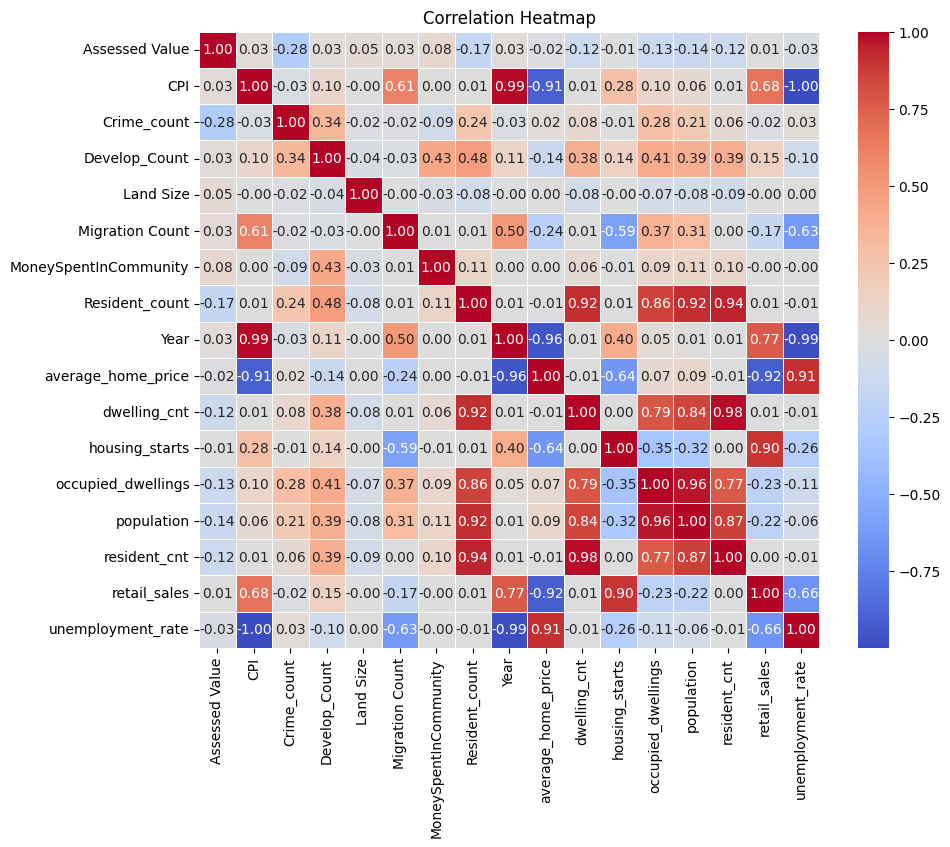

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=df_EDA.columns, outputCol="features")
df_vectorized = vector_assembler.transform(df_EDA)

# Compute correlation matrix
corr_matrix = Correlation.corr(df_vectorized, "features").head()

# Extract correlation matrix from the result
matrix = corr_matrix[0].toArray()

# Convert to Pandas DataFrame
import pandas as pd
corr_df = pd.DataFrame(matrix, columns=df_EDA.columns, index=df_EDA.columns)

# Plot heatmap using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")

plt.show()

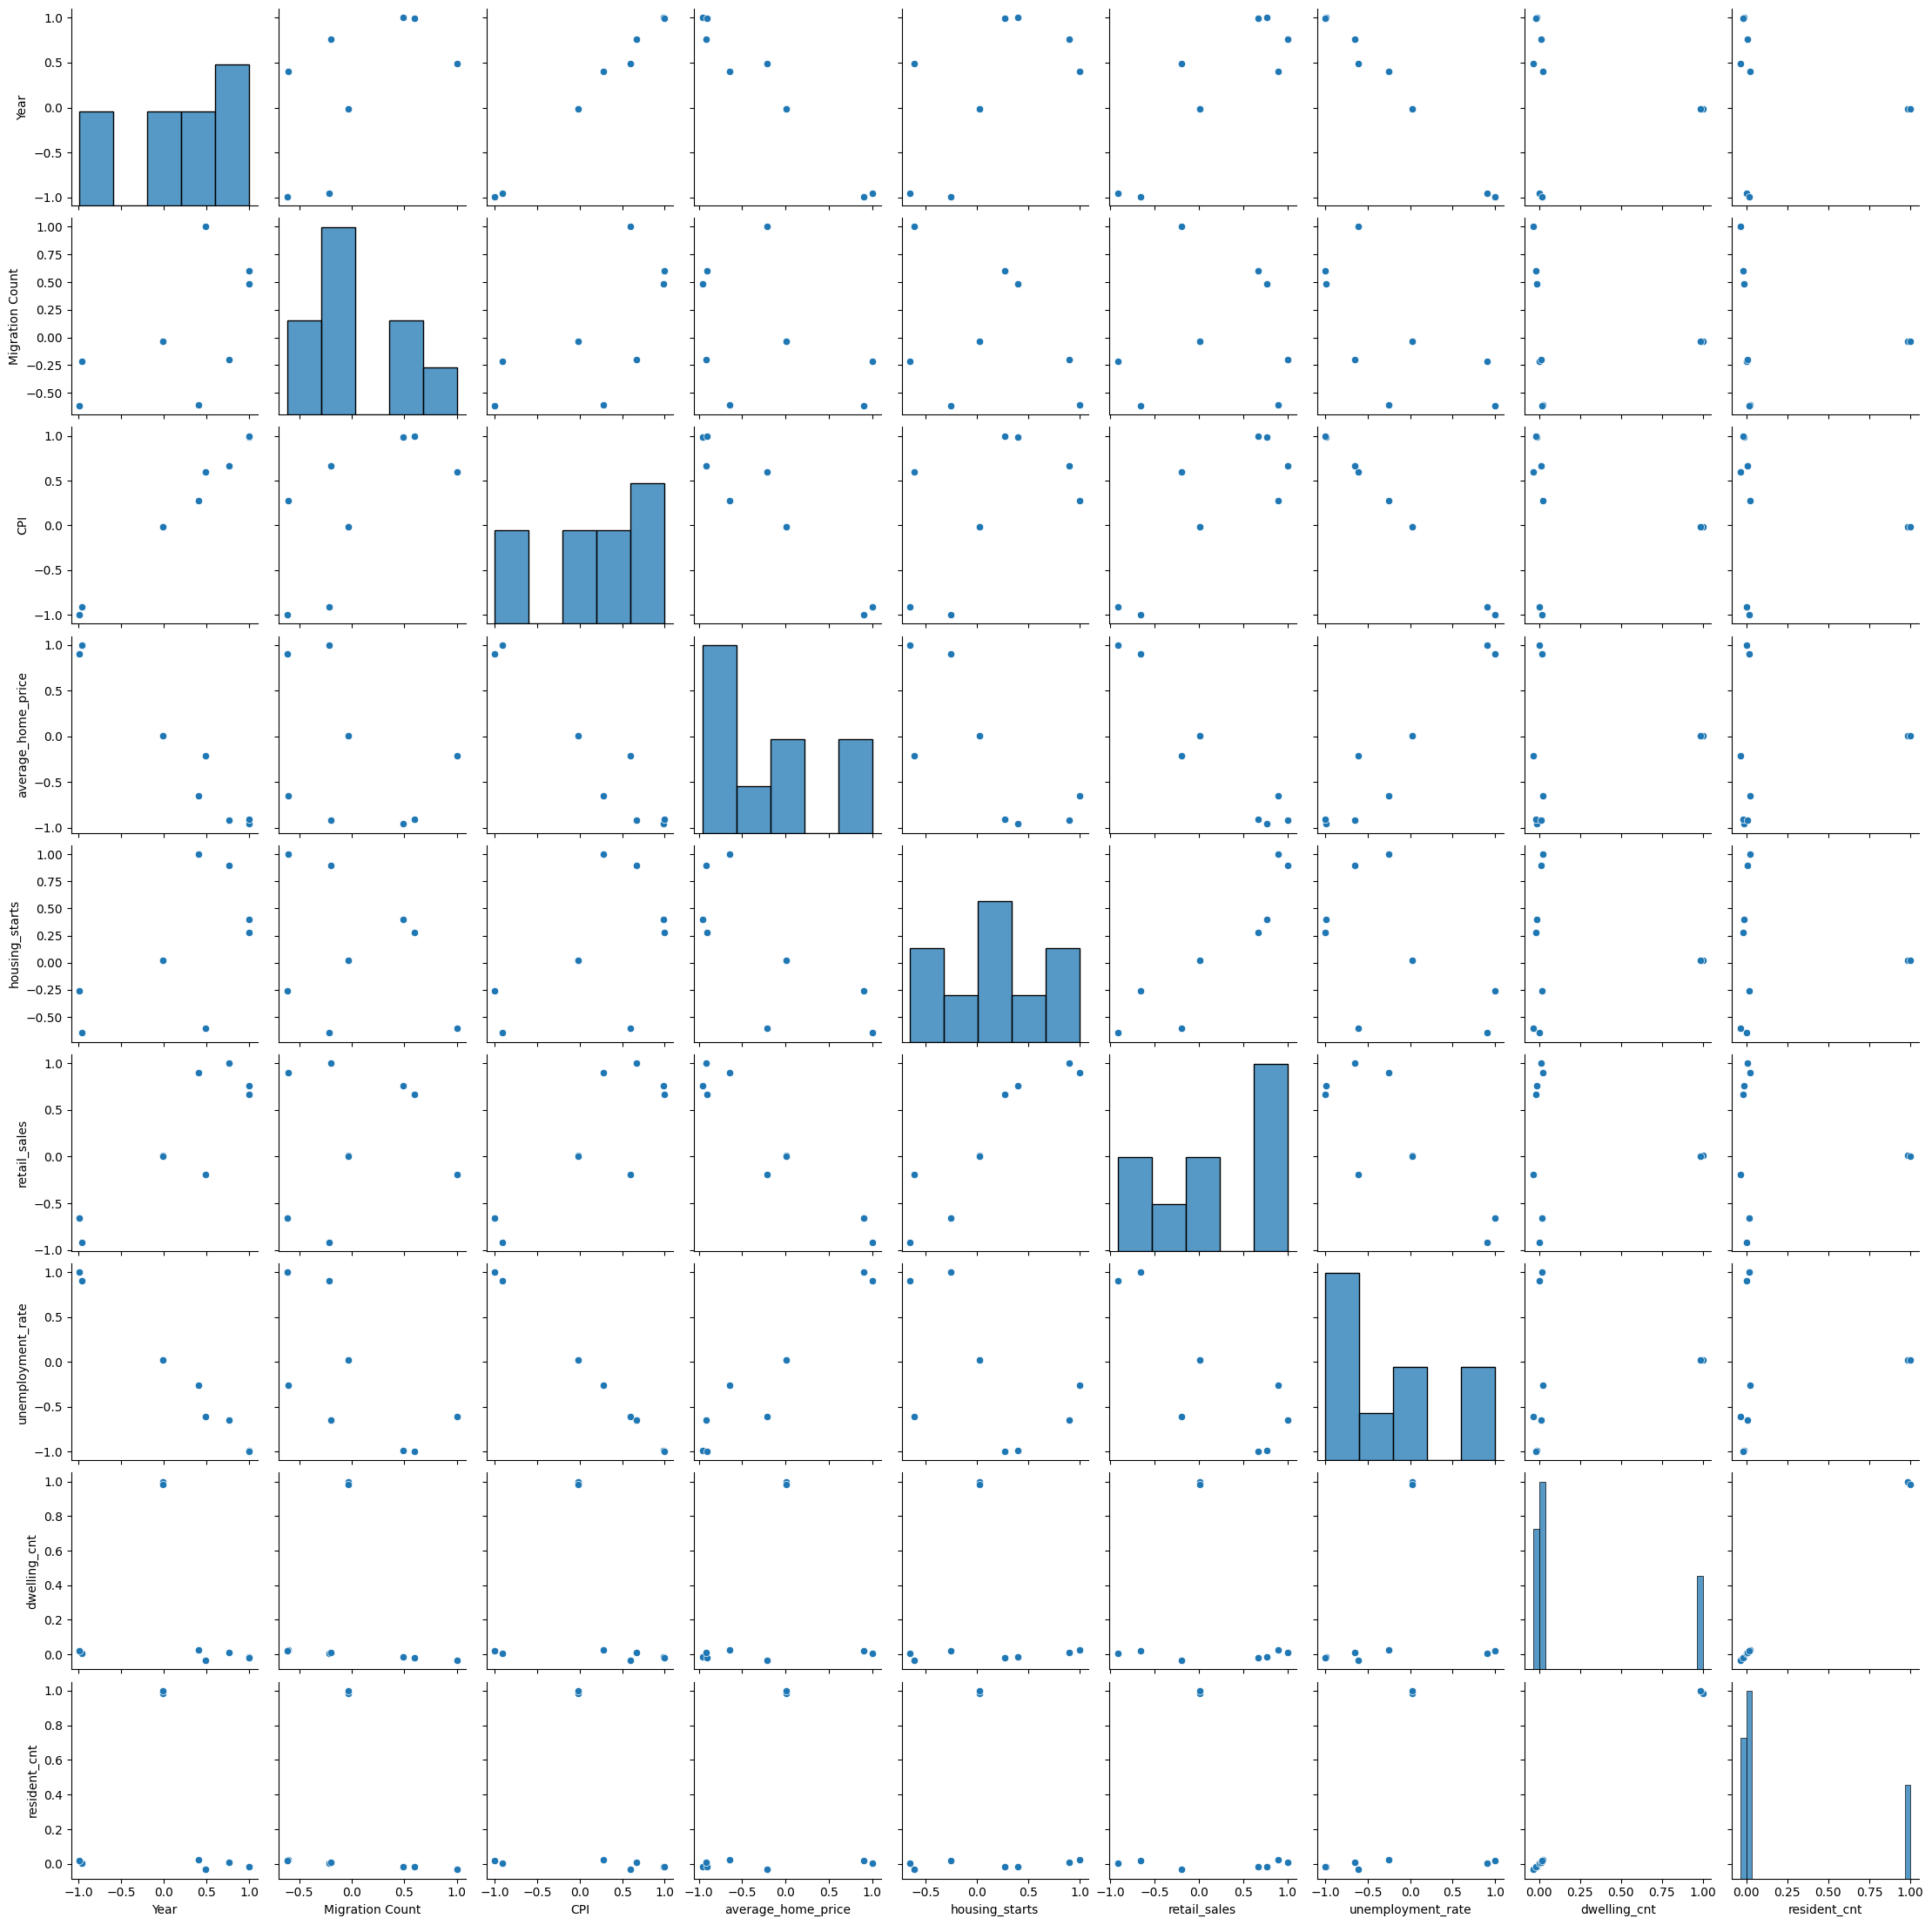

In [ ]:
#Macro-Scale Pair Plot

# List of columns to drop
columns_to_drop = ['Community_Code']

# Drop the specified columns
macro_df = macro_df.drop(*columns_to_drop)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=macro_df.columns, outputCol="features")
df_vectorized = vector_assembler.transform(macro_df)

# Compute correlation matrix
corr_matrix = Correlation.corr(df_vectorized, "features").head()

# Extract correlation matrix from the result
matrix = corr_matrix[0].toArray()

# Convert to Pandas DataFrame
import pandas as pd
corr_df = pd.DataFrame(matrix, columns=macro_df.columns, index=macro_df.columns)

#Pairplot
sns.pairplot(corr_df, kind='scatter')

plt.show()

In [ ]:
# Line Plots to Compare Feature Trends

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# List of columns to drop
columns_to_drop_scatter = ['Assessed Value','Develop_Count','Land Size','MoneySpentInCommunity','Resident_count','dwelling_cnt','occupied_dwellings','population','resident_cnt','retail_sales']

# Drop the specified columns
scatter_df = df_EDA.drop(*columns_to_drop_scatter)

scatter_df=scatter_df.distinct()

# Define the window specification
windowSpec = Window.partitionBy("Year")

# Calculate the yearly sum of Crime_count
crime_sum = scatter_df.withColumn("total_crime_count", F.sum("Crime_count").over(windowSpec))

# Join the data with the original DataFrame to update Crime_count
updated_df = scatter_df.join(crime_sum.select("Year", "total_crime_count"), on="Year")

# Select columns to maintain original DataFrame structure but with updated Crime_count
scatter_df_sum = updated_df.select(
    scatter_df["CPI"],
    scatter_df["Migration Count"],
    scatter_df["Year"],
    scatter_df["average_home_price"],
    scatter_df["housing_starts"],
    scatter_df["unemployment_rate"],
    "total_crime_count"
)
scatter_df_sum=scatter_df_sum.distinct()

# Convert to Pandas Dataframe for plotting
scatter_df_pd=scatter_df_sum.toPandas()
scatter_df_pd.head()

,CPI,Migration Count,Year,average_home_price,housing_starts,unemployment_rate,total_crime_count
0,1.228333,50396,2017,463366.666667,11534.0,8.558333,86199
1,1.805000,55147,2018,458100.000000,10971.0,7.633333,85800
2,2.166667,52796,2019,441825.000000,11909.0,7.091667,90126


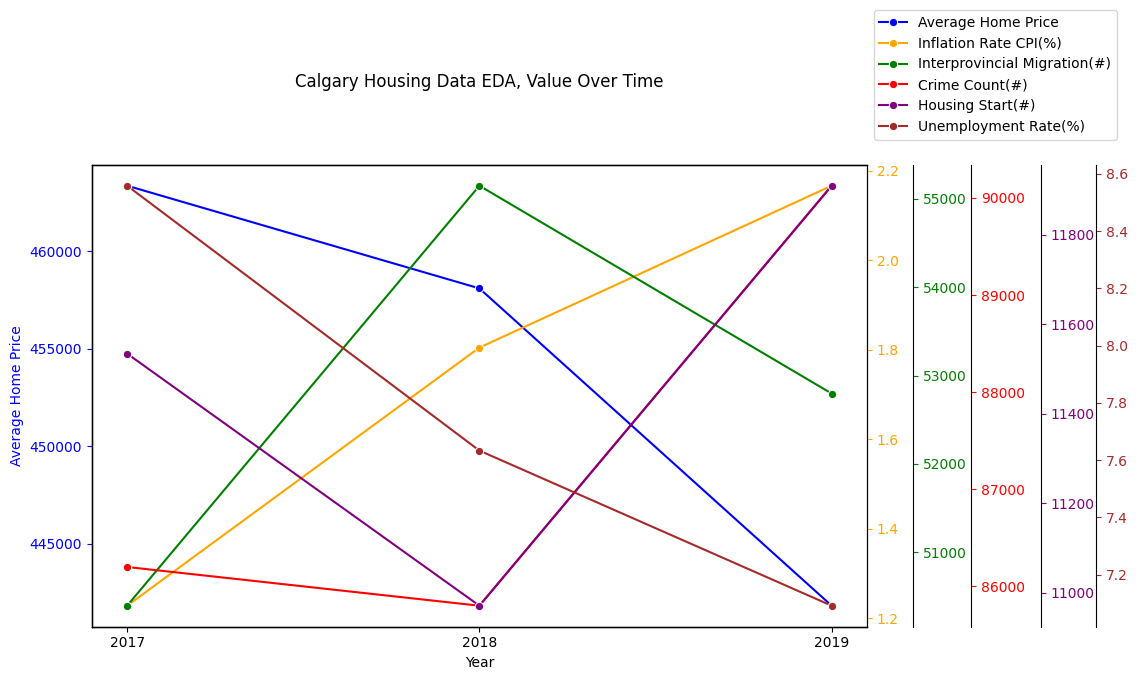

In [ ]:
# Create a figure and a set of subplots with twinx()
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()
ax6 = ax1.twinx()

# ax2.spines['right'].set_position(('outward', 25))
ax3.spines['right'].set_position(('outward', 33))
ax4.spines['right'].set_position(('outward', 75))
ax5.spines['right'].set_position(('outward', 125))
ax6.spines['right'].set_position(('outward', 165))

# Plot each feature on a separate y-axis

sns.lineplot(x='Year', y='average_home_price', data=scatter_df_pd, ax=ax1, marker='o', color='blue', label='Average Home Price', legend=False)
sns.lineplot(x='Year', y='CPI', data=scatter_df_pd, ax=ax2, marker='o', color='orange', label='Inflation Rate CPI(%)', legend=False)
sns.lineplot(x='Year', y='Migration Count', data=scatter_df_pd, ax=ax3, marker='o', color='green', label='Interprovincial Migration(#)', legend=False)
sns.lineplot(x='Year', y='total_crime_count', data=scatter_df_pd, ax=ax4, marker='o', color='red', label='Crime Count(#)', legend=False)
sns.lineplot(x='Year', y='housing_starts', data=scatter_df_pd, ax=ax5, marker='o', color='purple', label='Housing Start(#)', legend=False)
sns.lineplot(x='Year', y='unemployment_rate', data=scatter_df_pd, ax=ax6, marker='o', color='brown', label='Unemployment Rate(%)', legend=False)

# Set labels and title
ax1.set_ylabel('Average Home Price', color='blue')
plt.title('Calgary Housing Data EDA, Value Over Time',y=1.15)

# Set X-axis ticks to integers
plt.xticks(scatter_df_pd['Year'])

# Change the color of y-axis tick labels
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='orange')
ax3.tick_params(axis='y', colors='green')
ax4.tick_params(axis='y', colors='red')
ax5.tick_params(axis='y', colors='purple')
ax6.tick_params(axis='y', colors='brown')

# Combine legends from the three plots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines5, labels5 = ax5.get_legend_handles_labels()
lines6, labels6 = ax6.get_legend_handles_labels()
ax1.legend(lines+lines2+lines3+lines4+lines5+lines6, labels + labels2+ labels3+ labels4+ labels5 + labels6,bbox_to_anchor=(1, 1.35),  loc='upper left')

# Remove label for axis
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')

plt.show()

# Models

In [ ]:
num_rows = final_df.count()
print(f"Number of rows: {num_rows}")

Number of rows: 921507


In [ ]:
# Specify the weights for the random split
weights = [0.8, 0.2]

# Perform random split directly on the DataFrame
training_data, test_data = final_df.randomSplit(weights, seed=42)

training_data.show()

+--------------+------------------+--------------+-----------+-------------+---------+--------------------+---------------+---------------------+--------------+----+------------------+------------+--------------+------------------+----------+------------+--------------------+-----------------+
|Assessed Value|               CPI|Community_Code|Crime_count|Develop_Count|Land Size|Land Use Designation|Migration Count|MoneySpentInCommunity|Resident_count|Year|average_home_price|dwelling_cnt|housing_starts|occupied_dwellings|population|resident_cnt|        retail_sales|unemployment_rate|
+--------------+------------------+--------------+-----------+-------------+---------+--------------------+---------------+---------------------+--------------+----+------------------+------------+--------------+------------------+----------+------------+--------------------+-----------------+
|      287000.0|1.8049999999999993|           VAR|        737|           38|    331.6|                R-C2|        

#### Pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the columns to index and one-hot encode
columns_to_index = ["Community_Code", "Land Use Designation"]


# Create a list of StringIndexer stages
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in columns_to_index]

#List of Columns in Dataset
all_columns = ["CPI", "Crime_count", "Develop_Count",
               "Land Size", "Migration Count", "MoneySpentInCommunity",
               "Resident_count", "average_home_price", "dwelling_cnt",
               "housing_starts", "occupied_dwellings", "population",
               "resident_cnt", "retail_sales", "unemployment_rate"]

# Create a list of OneHotEncoder stages
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_encoded") for indexer in indexers]

# Create a VectorAssembler to combine indexed and encoded columns into a single vector
assembler_inputs = [encoder.getOutputCol() for encoder in encoders] + all_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")


### Decision Tree

In [ ]:
# Create the Decision Tree Regression model
dt_regressor = DecisionTreeRegressor(featuresCol="features",
                                     labelCol="Assessed Value",
                                     predictionCol="prediction",
                                     maxDepth=3,
                                     maxBins=12)

# Create the pipeline with StringIndexers, OneHotEncoders, VectorAssembler, and Decision Tree Regressor
pipeline = Pipeline(stages=indexers + encoders + [assembler, dt_regressor])

# Fit and transform the data
dt_model = pipeline.fit(training_data)
dt_df = dt_model.transform(training_data)

# Show the transformed DataFrame
dt_df.select("Assessed Value", "prediction").describe().show()


+-------+------------------+------------------+
|summary|    Assessed Value|        prediction|
+-------+------------------+------------------+
|  count|            737670|            737670|
|   mean|  522150.778554096|522150.77855409146|
| stddev|230951.96963214135|126614.60496444722|
|    min|           50000.0| 412988.2230689297|
|    max|         3000000.0| 1360903.494623656|
+-------+------------------+------------------+



#### Training Scores

In [ ]:
# Training R2 Score
dt_evaluator_train = RegressionEvaluator(predictionCol="prediction", labelCol="Assessed Value", metricName='r2')
dt_r2_score =dt_evaluator_train.evaluate(dt_df)
print("Training R2 score:", dt_r2_score)

Training R2 score: 0.3005552149729088


In [ ]:
# Training Root Mean Squared Error
dt_evaluator_train = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="rmse")
dt_rmse_score = dt_evaluator_train.evaluate(dt_df)
print(f"Training RMSE: {dt_rmse_score}")

Training RMSE: 193151.5040371326


In [ ]:
# Training Mean Absolute Error
dt_evaluator_train = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="mae")
dt_mae_score = dt_evaluator_train.evaluate(dt_df)
print(f"Training MAE: {dt_mae_score}")

Training MAE: 122116.92747411721


#### Testing Scores

In [ ]:
# Evaluate the model on test data
dt_test_predictions = dt_model.transform(test_data)

In [ ]:
# Testing R2 Score
dt_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="r2")
dt_r2_test = dt_evaluator_test.evaluate(dt_test_predictions)
print(f"Testing R2 score: {dt_r2_test}")

Testing R2 score: 0.3031102041363577


In [ ]:
# Testing Root Mean Squared Error
dt_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="rmse")
dt_rmse_test = dt_evaluator_test.evaluate(dt_test_predictions)
print(f"Testing RMSE: {dt_rmse_test}")

Testing RMSE: 194097.4865268364


In [ ]:
#Testing Mean Absolute Error
dt_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="mae")
dt_mae_test = dt_evaluator_test.evaluate(dt_test_predictions)
print(f"Testing MAE: {dt_mae_test}")

Testing MAE: 122248.74874840726


### Random Forest

In [ ]:
# Create the Random Forest Regression model
rf_regressor = RandomForestRegressor(featuresCol="features",
                                     labelCol="Assessed Value",
                                     predictionCol="prediction",
                                     numTrees=5,
                                     maxDepth=3,
                                     maxBins=12)

# Create the pipeline with StringIndexers, OneHotEncoders, VectorAssembler, and Random Forest Regressor
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf_regressor])

# Fit and transform the data
rf_model = pipeline.fit(training_data)
rf_df = rf_model.transform(training_data)

# Show the transformed DataFrame
rf_df.select("Assessed Value", "prediction").describe().show()


+-------+------------------+------------------+
|summary|    Assessed Value|        prediction|
+-------+------------------+------------------+
|  count|            737670|            737670|
|   mean|  522150.778554096| 522154.0258744721|
| stddev|230951.96963214135| 94844.04682258982|
|    min|           50000.0| 384935.7312727134|
|    max|         3000000.0|1221118.0539344735|
+-------+------------------+------------------+



#### Training Scores

In [ ]:
# Training R2 Score
rf_evaluator_train = RegressionEvaluator(predictionCol="prediction", labelCol="Assessed Value", metricName='r2')
rf_r2_score = rf_evaluator_train.evaluate(rf_df)
print("Training R2 score:", rf_r2_score)

Training R2 score: 0.328071934057403


In [ ]:
# Training Root Mean Squared Error
rf_evaluator_train = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="rmse")
rf_rmse_train = rf_evaluator_train.evaluate(rf_df)
print(f"Training RMSE: {rf_rmse_train}")

Training RMSE: 189314.01529663897


In [ ]:
# Training Mean Absolute Error
rf_evaluator_train = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="mae")
rf_mae_train = rf_evaluator_train.evaluate(rf_df)
print(f"Training MAE: {rf_mae_train}")

Training MAE: 116548.80582546536


#### Testing Scores

In [ ]:
# Evaluate the model on test data
rf_test_predictions = rf_model.transform(test_data)

In [ ]:
# Testing R2 Score
rf_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="r2")
rf_r2_test = rf_evaluator_test.evaluate(rf_test_predictions)
print(f"Testing R2 score: {rf_r2_test}")

Testing R2 score: 0.32864712554234077


In [ ]:
# Testing Root Mean Squared Error
rf_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="rmse")
rf_rmse_test = rf_evaluator_test.evaluate(rf_test_predictions)
print(f"Testing RMSE: {rf_rmse_test}")

Testing RMSE: 190508.02957907395


In [ ]:
#Testing Mean Absolute Error
rf_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="mae")
rf_mae_test = rf_evaluator_test.evaluate(rf_test_predictions)
print(f"Testing MAE: {rf_mae_test}")

Testing MAE: 117120.82178238743


### Linear Regression

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create the Linear Regression model
lr_regressor = LinearRegression(featuresCol="features", labelCol="Assessed Value", predictionCol="prediction")

# Create the pipeline with StringIndexers, OneHotEncoders, VectorAssembler, and Linear Regression
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr_regressor])

# Create a ParamGridBuilder to specify the hyperparameters to tune.
paramGrid = ParamGridBuilder() \
    .addGrid(lr_regressor.maxIter, [10, 20, 30]) \
    .addGrid(lr_regressor.regParam, [0.01, 0.05, 0.1]) \
    .build()


evaluator = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="r2")

cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=paramGrid,
                                 evaluator=evaluator,
                                 numFolds=5)

# Perform cross validation
cvModel = cross_validator.fit(training_data)

# Fit and transform the data
lr_df = cvModel.transform(test_data)

# Show the transformed DataFrame
lr_df.select("Assessed Value", "prediction").describe().show()

+-------+------------------+------------------+
|summary|    Assessed Value|        prediction|
+-------+------------------+------------------+
|  count|            183837|            183837|
|   mean| 522372.1751116478|522148.61206466093|
| stddev|232508.61007913278|169805.12661882016|
|    min|           51500.0|  226220.404661756|
|    max|         3000000.0|1840984.2044857088|
+-------+------------------+------------------+



In [ ]:
# Show best parameters of cvModel
best_model = cvModel.bestModel

best_model_params = best_model.stages[-1].extractParamMap()

for param,val in best_model_params.items():
  print(param.name, " : ", val)

aggregationDepth  :  2
elasticNetParam  :  0.0
epsilon  :  1.35
featuresCol  :  features
fitIntercept  :  True
labelCol  :  Assessed Value
loss  :  squaredError
maxBlockSizeInMB  :  0.0
maxIter  :  10
predictionCol  :  prediction
regParam  :  0.01
solver  :  auto
standardization  :  True
tol  :  1e-06


#### Training Scores

In [ ]:
# Training R2 Score
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Assessed Value", metricName='r2')
lr_r2_score = lr_evaluator.evaluate(lr_df)
print("Training R2 score:", lr_r2_score)

Training R2 score: 0.5409286686624446


In [ ]:
# Training Root Mean Squared Error
lr_evaluator_train = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="rmse")
lr_rmse_train = lr_evaluator_train.evaluate(lr_df)
print(f"Training RMSE: {lr_rmse_train}")

Training RMSE: 157535.3219728833


In [ ]:
# Training Mean Absolute Error
lr_evaluator_train = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="mae")
lr_mae_train = lr_evaluator_train.evaluate(lr_df)
print(f"Training MAE: {lr_mae_train}")

Training MAE: 88922.0436103032


#### Testing Scores

In [ ]:
# Evaluate the model on test data
cv_lr_test_predictions = cvModel.transform(test_data)

In [ ]:
# Testing R2 Score
lr_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="r2")

# lr_r2_test = lr_evaluator_test.evaluate(lr_test_predictions)
lr_r2_test = lr_evaluator_test.evaluate(cv_lr_test_predictions)
print(f"Testing R2 score: {lr_r2_test}")

Testing R2 score: 0.5409286686624446


In [ ]:
# Testing Root Mean Squared Error
lr_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="rmse")
lr_rmse_test = lr_evaluator_test.evaluate(cv_lr_test_predictions)
print(f"Testing RMSE: {lr_rmse_test}")

Testing RMSE: 157535.3219728833


In [ ]:
#Testing Mean Absolute Error
lr_evaluator_test = RegressionEvaluator(labelCol="Assessed Value", predictionCol="prediction", metricName="mae")
lr_mae_test = lr_evaluator_test.evaluate(cv_lr_test_predictions)
print(f"Testing MAE: {lr_mae_test}")

Testing MAE: 88922.0436103032


# Model Summary Results

In [ ]:
import pandas as pd

results = pd.DataFrame()
results_list = [(dt_rmse_score,dt_rmse_test, dt_mae_score, dt_mae_test, dt_r2_score, dt_r2_test),
                (rf_rmse_train,rf_rmse_test, rf_mae_train, rf_mae_test, rf_r2_score, rf_r2_test),
                (lr_rmse_train,lr_rmse_test, lr_mae_train, lr_mae_test, lr_r2_score, lr_r2_test) ]

results = pd.DataFrame(results_list,
                       columns=['Train RMSE', 'Test RMSE',
                                'Train MAE','Test MAE',
                                'Train R2', ' Test R2'],
                       index = ["Decision Tree", "Random Forest",
                                "Linear Regression"])
results

,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
Decision Tree,193151.504037,194097.486527,122116.927474,122248.748748,0.300555,0.303110
Random Forest,189314.015297,190508.029579,116548.805825,117120.821782,0.328072,0.328647
Linear Regression,157535.321973,157535.321973,88922.043610,88922.043610,0.540929,0.540929


# End Spark Context

In [ ]:
sc.stop()